# Configuration

In [57]:
# ES connector config
es_user = 'admin'
es_pass = 'admin'
es_host = 'elasticsearch-1'
es_port = 9200
auth=(es_user, es_pass)

In [58]:
# samples postgres connector config
pg_user = 'test'
pg_pass = 'test'
pg_host = 'samples-db'
pg_port = 5432
pg_db_name = "db_samples"

# Init and import libraries

In [82]:
%matplotlib inline

# data wrangling + vis
import pandas as pd
import pandas.io.sql as psql
from matplotlib import pyplot as plt
import ssl
# databases
import elasticsearch
import elasticsearch.helpers
from elasticsearch.connection import create_ssl_context

# postgres
import psycopg2 as pg

# ms sql
import pyodbc


# Init connectors (Elasticsearch version)

In [62]:
# Creating ElasticSearch connector
#

es = elasticsearch.Elasticsearch( hosts=[ { 'port': 9200, 'host': es_host } ], ssl_context=None, verify_certs=False, http_auth=auth , timeout=600, scroll='2m')


# check status
print('checking ES connection ...')
if not es.ping():
    raise Exception("Connection failed")
print('connected to ES')

In [79]:
# PostgreSQL connector
#
print('connecting to PostgreSQL ...')
pg_conn = pg.connect(database=pg_db_name,user=pg_user, password=pg_pass, host=pg_host, port=pg_port)

print('connected to PostgreSQL')

connecting to PostgreSQL ...
connected to PostgreSQL


# Example queries

In [80]:
def print_plot(cui_occ):
    cui_names = []
    cui_counts = []

    for cui, cnt in sorted(cui_occ.items(), key=lambda kv: kv[1], reverse=True):
        cui_names.append(cui)
        cui_counts.append(cnt)

    # display the results
    plt.figure(figsize=(25,8))

    plt.bar(range(len(cui_names)), list(cui_counts), align='center')
    plt.xticks(range(len(cui_occ)), list(cui_names), rotation=90)

    plt.tick_params(axis='x', which='major', labelsize=20)
    plt.tick_params(axis='y', which='major', labelsize=20)

    plt.show()

## ElasticSearch

### Direct data manipulations

In [83]:
# example 1:
# retrieve the number of documents satisfying the query criteria
#
# an example query -- search for keyword 'cancer' in documents
query_body_text = {
    "query": {
        "match": {
            "document": "cancer"}
    }
}
index_to_query_text = 'medical_reports_text'

documents = es.search(index=index_to_query_text, body=query_body_text)

print(documents['hits']['total'])

{'value': 45, 'relation': 'eq'}


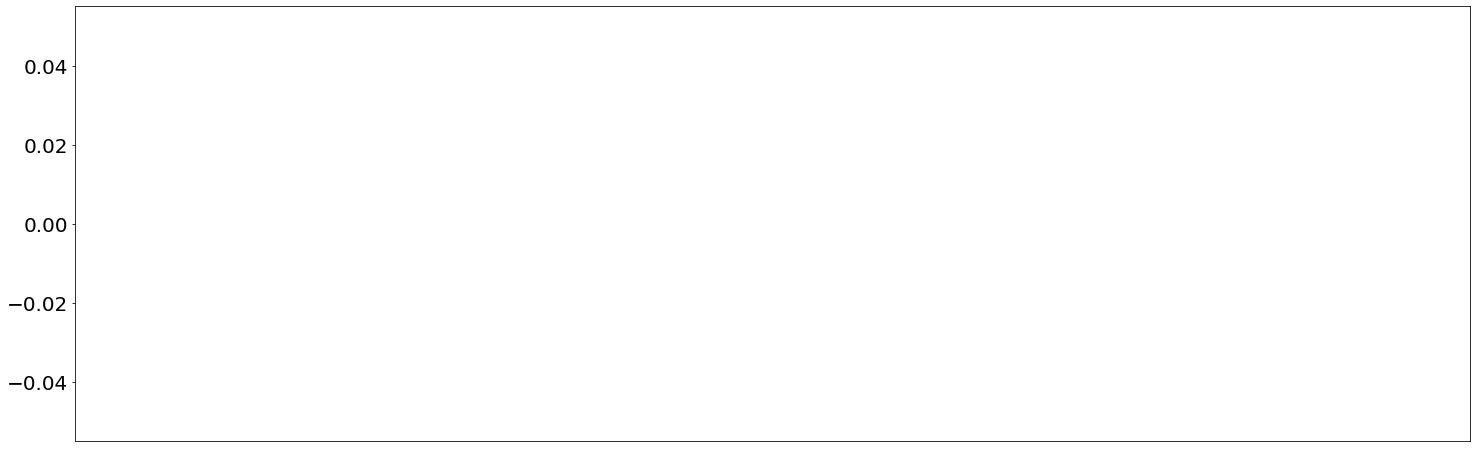

In [85]:
# example 2:
# - retrieve all the documents matching the query criteria 
# - calculate the CUI codes occurencies
# - visualize the results

query_body_medcat = {
    "query": {
        "match": {
            "nlp.source_value": "skin"}
    }
}
index_to_query_medcat = "medical_reports_anns_medcat_medmen_cancer"

# query the elasticsearch
results = elasticsearch.helpers.scan(es, index=index_to_query_medcat, query=query_body_medcat)

# calculate the occurencies
bio_cui_occ = {}
bio_tui_arr = {}
for item in results:
    cui = item['_source']['nlp.pretty_name']
    if cui not in bio_cui_occ: 
        bio_cui_occ[cui] = 1
    else:
        bio_cui_occ[cui] += 1
    
    tui = item['_source']['nlp.tui']
    if tui not in bio_tui_arr:
         bio_tui_arr[tui] = set()
    bio_tui_arr[tui].add(cui)
    

print_plot(bio_cui_occ)

In [73]:
# example 2:
# - retrieve all the documents matching the query criteria 
# - calculate the CUI codes occurencies
# - visualize the results

def get_tui_cui_occ(es, index_name, cui_field_name, tui_field_name, query_field_name, query_phrase):
    # query the elasticsearch
    query = {
        "query": {
            "match": {
               query_field_name : query_phrase}
        }
    }
    results = elasticsearch.helpers.scan(es, index=index_name, query=query)

    # calculate the occurencies
    cui_occ = {}
    tui_arr = {}
    for item in results:
        #cui = (item['_source']['nlp.inst'], item['_source']['nlp.text'])
        cui = item['_source'][cui_field_name]
        if cui not in cui_occ: 
            cui_occ[cui] = 1
        else:
            cui_occ[cui] += 1

        tui = item['_source'][tui_field_name]
        if tui not in tui_arr:
             tui_arr[tui] = set()
        tui_arr[tui].add(cui)
    
    return (cui_occ, tui_arr)

In [74]:
#bioyodie_results = get_tui_cui_occ(es, 'nifi_is_doc_gp_refletters_bioyodie', 'nlp.inst', 'nlp.TUI', 'nlp.text', 'cancer')
medcat_results = get_tui_cui_occ(es, 'medical_reports_anns_medcat_medmen_cancer', 'nlp.cui', 'nlp.tui', 'nlp.source_value', 'skin')

#print_plot(bioyodie_results[0])
print_plot(medcat_results[0])

TypeError: search() got an unexpected keyword argument 'query'

### Using Pandas

In [19]:
# query template
#
query_body_medcat = {
    "query": {
        "match": {
            "nlp.source_value": "skin"}
    }
}

index_to_query_medcat = 'medical_reports_anns_medcat_medmen_cancer'


# need to re-query ES to fetch the results
#
results = elasticsearch.helpers.scan(es, index=index_to_query_medcat, query=query_body_medcat)


# create a data frame from the results
#
es_df = pd.DataFrame.from_dict([item['_source'] for item in results])
es_df.head()

,meta.dct,meta.docid,meta.filename,meta.sampleid,meta.typeid,nlp.acc,nlp.cui,nlp.end,nlp.id,nlp.info,nlp.meta_anns,nlp.pretty_name,nlp.source_value,nlp.start,nlp.tui,nlp.type
0,2020-07-13T08:57:24.401,95,__tmp/txt/mtsamples-type-98-sample-2057.txt,2057,98,1,C0007114,1603,56,{},{},skin cancer,skin cancers,1591,T191,Neoplastic Process
1,2020-04-10T20:02:17.349,82,__tmp/txt/mtsamples-type-98-sample-1934.txt,1934,98,1,C0007114,4709,135,{},{},skin cancer,skin cancers,4697,T191,Neoplastic Process
2,2020-05-14T04:02:33.197,171,__tmp/txt/mtsamples-type-98-sample-2783.txt,2783,98,1,C0037297,866,27,{},{},skin grafting,skin grafting,853,T061,Therapeutic or Preventive Procedure
3,2019-10-18T01:36:11.854,184,__tmp/txt/mtsamples-type-98-sample-381.txt,381,98,1,C0037284,4870,128,{},{},skin lesions,skin lesions,4858,T047,Disease or Syndrome
4,2019-12-04T04:18:07.580,125,__tmp/txt/mtsamples-type-98-sample-2310.txt,2310,98,1,C0037284,2908,104,{},{},skin lesions,skin lesions,2896,T047,Disease or Syndrome


In [22]:
# select only a subset of columns and perform filtering based on TUI and CUI
es_df_sub = es_df.filter(items=['meta.docid', 'nlp.source_value', 'nlp.cui', 'nlp.tui'])
rows = es_df_sub.loc[(es_df_sub['nlp.tui'] == 'T191')]

print(rows[0:10])

   meta.docid nlp.source_value   nlp.cui nlp.tui
0          95     skin cancers  C0007114    T191
1          82     skin cancers  C0007114    T191


## PostgreSQL (samples-db)

In [28]:
# example: read the DB and create pandas data frame
#
pg_df = pd.read_sql('SELECT docid, sampleid, dct FROM medical_reports_text', pg_conn)
pg_df.head()

,docid,sampleid,dct
0,1,1041,2019-10-30 16:53:58.476127
1,2,1042,2019-10-07 23:38:43.876148
2,3,1054,2019-12-02 17:05:18.100627
3,4,1068,2020-08-03 03:19:12.581134
4,5,1069,2020-03-14 06:47:10.383254
